In [ ]:
from notebook_include_fastfusion import *
# targets = {
#     "FastFusion": fastfusion_full
# }

from fastfusion.joining.simexplore import fuse_sims as fuse_sims_fastfusion
from fastfusion.joining.simexplore import fuse_sims_no_skip_invalid as fuse_sims_no_skip_invalid
from fastfusion.joining.simexplore import fuse_sims_no_combine_reservations as fuse_sims_no_combine_reservations
from fastfusion.joining.simexplore import fuse_sims_no_either as fuse_sims_no_either

results = {}

storage_filter = {}
storage_filter = storage_filter or set()

def get_gpt_shapes(batch=32, n_tokens=2048):
    for parameterization, shape in [
        # ("test", dict(B=2, H=2, M=2, E=2, D=2*2, C=2, J=2, G=2)),
        ("6.7B", dict(B=batch, H=32, M=n_tokens, E=128, D=32*128, C=16384, J=4096, G=4096)),
        # ("13B", dict(B=batch, H=40, M=n_tokens, E=128, D=40*128, C=20480, J=5120, G=5120)),
    ]:
        shape = {k: v for k, v in shape.items()}
        shape = {k: max(1, v) for k, v in shape.items()}
        shape["D"] = shape["H"] * shape["E"]
        yield f"{parameterization} B={batch} M={n_tokens}", shape

def get_matmul_shapes():
    for parameterization, shape in [
        # ("unbalanced", dict(M=128, N1=256, N2=128)),
        ("unbalanced", dict(M=8192, N1=16384, N2=4096)),
        # ("unbalanced", dict(M=32768, N1=4096, N2=2048)),
        # ("unbalanced", dict(M=32768, N1=32768, N2=128)),
        # ("balanced", dict(M=4096, N1=4096, N2=4096)),
    ]:
        yield parameterization, shape
        
def get_batch_n_tokens_choices():
    for batch, n_tokens in [
        (1, 1024),
        # (4, 1024),
        # (16, 1024),
        # (1, 2048),
        # (4, 2048),
        # (4, 4096),
        # (16, 2048),
        # (1, 16384),
        # (4, 16384),
        # (16, 16384),
    ]:
        yield batch, n_tokens

exp_args = dict(
    load_inter=False,
    load_intra=True,
    storage_filter=storage_filter,
    save_results=True,
)

def iter_gpt(exp_args):
    exp_args["workload_name"] = "mha_full"
    for batch, n_tokens in get_batch_n_tokens_choices():
        for parameterization, shape in get_gpt_shapes(batch=batch, n_tokens=n_tokens):
            args = exp_args.copy()
            args["shape"] = shape
            yield parameterization, args
            
def get_matmuls_function(n_matmuls):
    def iter_matmuls(exp_args):
        exp_args["workload_name"] = f"matmuls{n_matmuls}"
        for parameterization, shape in get_matmul_shapes(): 
            args = exp_args.copy()
            args["shape"] = shape
            yield parameterization, args
    return iter_matmuls

def iter_both(exp_args):
    # yield from get_matmuls_function(1)(exp_args)
    # yield from get_matmuls_function(2)(exp_args)
    # yield from get_matmuls_function(4)(exp_args)
    yield from get_matmuls_function(8)(exp_args)
    # yield from iter_gpt(exp_args)
    # yield from get_matmuls_function(16)(exp_args)
    # yield from get_matmuls_function(32)(exp_args)
    # yield from get_matmuls_function(64)(exp_args)

workload_generator = iter_gpt
# workload_generator = get_matmuls_function(4) # Works up to 32. 64 is hacky

def experiment_generator():
    for parameterization, args in workload_generator(exp_args):
        for prune_intra, taggers, callfunc, fuse_function, dataflow, fuse, name in [
            (True, tuple(), fastfusion_full, fuse_sims_fastfusion, None, True, "Fastfusion"),
            
            # Other experiments for the paper
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_no_skip_invalid, None, True, "Fastfusion No Skip Invalid"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_no_combine_reservations, None, True, "Fastfusion No Combine Reservations"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_no_either, None, True, "Fastfusion No Skip Invalid Or Combine Reservations"),
            # (False, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_simulated_anneal, None, True, "Simulated Annealing"),
            # (False, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_genetic, None, True, "Genetic"),
            # (False, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_random, None, True, "Random"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_simulated_anneal, None, True, "Simulated Annealing + Pruning"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_genetic, None, True, "Genetic + Pruning"),
            # (True, (get_layernorm_tag_mha,), fastfusion_full, fuse_sims_random, None, True, "Random + Pruning"),

        ]:
            yield parameterization, args, prune_intra, taggers, callfunc, fuse_function, dataflow, fuse, name

# Generate single-Einsum pmappings
for parameterization, args, prune_intra, taggers, callfunc, fuse_function, dataflow, fuse, name in experiment_generator():
    print(f'\n' * 3)
    print(f'Running {parameterization} {name} intra-layer exploration')
    for k, v in args.items():
        print(f'\t{k}: {v}')
    exp = run_experiment(
        name=name, 
        callfunction=callfunc,
        lookahead_filter=True,
        prune_intra=prune_intra,
        taggers=taggers,
        fuse_function=fuse_function,
        **args,
        run_inter=False,
        dataflow=dataflow,
        fuse=fuse,
    )
    if getattr(exp, "intra_result", None) is None:
        exp.load_intra_results()
    for_name_str = [args["workload_name"], args["shape"], prune_intra] + [t.__name__ for t in taggers]
    name_str = " | ".join(str(s) for s in for_name_str)
    n_returned_mappings = sum(len(s.mappings.data) for sims in exp.intra_result.values() for s in sims)
    print(f'{name_str} intra mappings: {exp.n_mappings_intra}')
    print(f'{name_str} returned intra mappings: {n_returned_mappings}')

# Generate multi-Einsum pmappings
results = {}
key2stop_at_score = {}
key2max_evaluations = {}
speed = {}
for parameterization, args, prune_intra, taggers, callfunc, fuse_function, dataflow, fuse, name in experiment_generator():
    print(f'\n' * 3)
    print(f'Running {parameterization} {name} inter-layer exploration')
    for k, v in args.items():
        print(f'\t{k}: {v}')
    args['load_intra'] = True
    key = str((parameterization, args))
    exp = run_experiment(
        name=name, 
        callfunction=callfunc,
        lookahead_filter=True,
        prune_intra=prune_intra,
        taggers=taggers,
        fuse_function=fuse_function,
        **args,
        dataflow=dataflow,
        fuse=fuse,
        stop_at_score=key2stop_at_score.get(key, None),
        max_evaluations=key2max_evaluations.get(key, None),
    )
    if key not in key2max_evaluations:
        key2max_evaluations[key] = exp.n_mappings_inter.evaluations * 1200
        key2stop_at_score[key] = exp.n_mappings_inter.score * 1.01
    inter_result = exp.inter_result
    inter_result["EDP"] = inter_result["Energy"] * inter_result["Latency"]
    edp = inter_result["EDP"].min()
    for_name_str = [args["workload_name"], args["shape"], prune_intra] + [t.__name__ for t in taggers] + [name]
    name_str = " | ".join(str(s) for s in for_name_str)
    print(f'{name_str} intra mappings: {exp.n_mappings_intra}')
    print(f'{name_str} inter mappings: {exp.n_mappings_inter}')
    print(f'{name_str} EDP: {edp}')
    results[name_str] = exp
    speed[name] = exp.n_mappings_inter





Running 6.7B B=2 M=64 Fastfusion intra-layer exploration
	load_inter: False
	load_intra: True
	storage_filter: set()
	save_results: True
	workload_name: mha_full
	shape: {'B': 2, 'H': 32, 'M': 64, 'E': 128, 'D': 4096, 'C': 16384, 'J': 4096, 'G': 4096}
mha_full | {'B': 2, 'H': 32, 'M': 64, 'E': 128, 'D': 4096, 'C': 16384, 'J': 4096, 'G': 4096} | True intra mappings: 1455823
mha_full | {'B': 2, 'H': 32, 'M': 64, 'E': 128, 'D': 4096, 'C': 16384, 'J': 4096, 'G': 4096} | True returned intra mappings: 11376




Running 6.7B B=2 M=64 Fastfusion inter-layer exploration
	load_inter: False
	load_intra: True
	storage_filter: set()
	save_results: True
	workload_name: mha_full
	shape: {'B': 2, 'H': 32, 'M': 64, 'E': 128, 'D': 4096, 'C': 16384, 'J': 4096, 'G': 4096}
Do the optimization where we put all the full mappings in a dict and grab them later
SIM I tensors: {'I_n_to_I', 'I_I_to_Q_K_V'}
SIM V tensors: {'W_n_to_V', 'V_V_to_AV', 'I_I_to_Q_K_V'}
SIM K tensors: {'K_K_to_QK', 'W_n_to_K', 'I_I_t

Inital consolidate FFB: 100%|██████████| 63/63 [00:00<00:00, 84099.67it/s]


Initial consolidate and group: 8.42 seconds

Einsum V (2/9)
Consolidating: 0.00 seconds
Combining: 0.01 seconds
Grouping: 0.00 seconds
Bucket merging: 0.01 seconds
Removed 77/148 (47.97% remaining)
Removing mappings that can't be combined later: 0.00 seconds


Merging mappings I <--> V: 100%|██████████| 71/71 [00:00<00:00, 24692.83it/s]


Mapping merging: 0.15 seconds
Scaled runtime by 1.0. Runtime: 0.08
	Combining 1675(633) x 549(183) -> 71
	Number of buckets for Einsum V: 71
	Number of mappings for Einsum V: 98
	Mappings per bucket for Einsum V: 1.380281690140845

Einsum K (3/9)
Consolidating: 0.01 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.02 seconds
Removed 0/514 (100.00% remaining)
Removing mappings that can't be combined later: 0.01 seconds


Merging mappings V <--> K: 100%|██████████| 514/514 [00:01<00:00, 264.43it/s] 


Mapping merging: 2.15 seconds
Scaled runtime by 1.0. Runtime: 0.08
	Combining 92(41) x 549(183) -> 514
	Number of buckets for Einsum K: 514
	Number of mappings for Einsum K: 1015
	Mappings per bucket for Einsum K: 1.9747081712062258

Einsum Q (4/9)
Consolidating: 0.00 seconds
Combining: 0.00 seconds
Grouping: 0.00 seconds
Bucket merging: 0.05 seconds
Removed 1134/2051 (44.71% remaining)
Removing mappings that can't be combined later: 0.03 seconds


Merging mappings K <--> Q: 100%|██████████| 917/917 [00:01<00:00, 806.09it/s] 


Mapping merging: 1.40 seconds
Scaled runtime by 1.0. Runtime: 0.08
	Combining 744(240) x 549(183) -> 917
	Number of buckets for Einsum Q: 917
	Number of mappings for Einsum Q: 1638
	Mappings per bucket for Einsum Q: 1.786259541984733

Einsum QK (5/9)
Consolidating: 0.02 seconds


Combining SIMs: 100%|██████████| 27/27 [00:00<00:00, 8206.84it/s]

Combining: 0.13 seconds
Grouping: 0.00 seconds


Bucket merging: 0.16 seconds
Removed 0/3461 (100.00% remaining)
Removing mappings that can't be combined later: 0.03 seconds


Merging mappings Q <--> QK:  70%|███████   | 2432/3461 [00:05<00:01, 548.48it/s]

In [2]:
# SIM: Track all aliased tensors. Once we combine two Einsums, if we have an alias
# in our reservations, then subtract one of them.

# Process results: Given a list of (tensor, alias) pairs, if an 

from collections import defaultdict
import importlib
import numpy as np
import fastfusion.visualization.interactive as interactive
import fastfusion.visualization.reservationtree as looptree
from tqdm import tqdm
from IPython.display import display, SVG
importlib.reload(interactive)
importlib.reload(looptree)
import pandas as pd
to_plot = {k: exp.inter_result for k, exp in results.items()}
from fastfusion.visualization.interactive import mapping2svg
interactive.plotly_show(to_plot, "Energy", "Latency", logscales=1, mapping_svg=True)

    'data': [{'line': {'shape': 'hv'},
              'marker': {'symbol': 'circl…

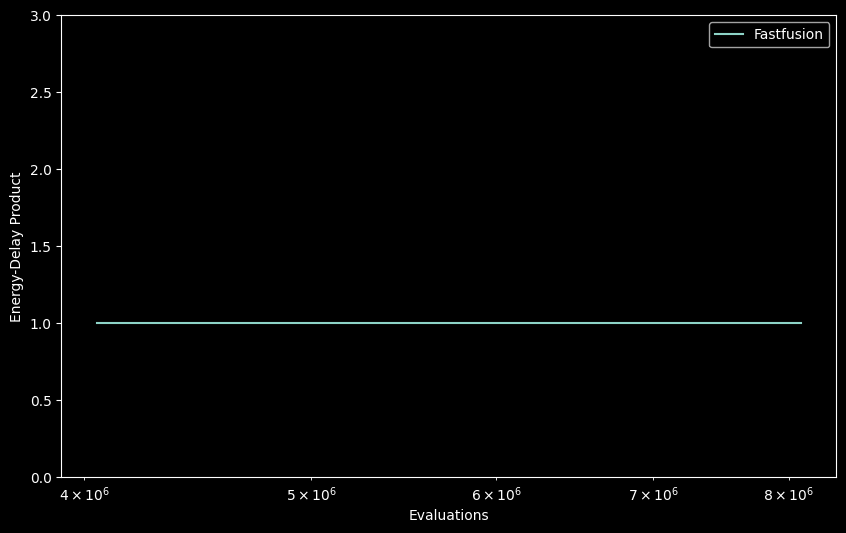

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

speed_to_plot = {k: v.history for k, v in speed.items()}
speed_to_plot = copy.deepcopy(speed_to_plot)
speed_to_plot = {k.split('|')[-1].strip(): v for k, v in speed_to_plot.items()}
speed_to_plot = {k: v for k, v in list(speed_to_plot.items())[::-1]}
fastfusion_min_score = min(v[1] for v in speed_to_plot["Fastfusion"])
fastfusion_n_evaluations = max(x[0] for x in speed_to_plot["Fastfusion"])
# Make sure all scores are >= fastfusion_min_score
for k, v in speed_to_plot.items():
    v = [(x[0], max(x[1], fastfusion_min_score)) for x in v]
    speed_to_plot[k] = v

# Normalize to fastfusion
for k, v in speed_to_plot.items():
    v = [(x[0], x[1] / fastfusion_min_score) for x in v]
    speed_to_plot[k] = v

# fastfusion_n_evaluations = min(x[0] for x in speed_to_plot["Fastfusion"])
# Remove inf values
inf = float("inf")
speed_to_plot = {k: list(filter(lambda x: x[1] != inf, v)) for k, v in speed_to_plot.items()}
max_evaluations = max(max(v2[0] for v2 in v) for v in speed_to_plot.values())
if max_evaluations == fastfusion_n_evaluations:
    max_evaluations *= 2
min_score = min(min(v2[1] for v2 in v) for v in speed_to_plot.values())
for k, v in speed_to_plot.items():
    v.append((max_evaluations, v[-1][1]))
# History is a list of tuples (score, evaluations)
fig, ax = plt.subplots(figsize=(10, 6))
for k, v in speed_to_plot.items():
    v = np.array(v)
    ax.plot(v[:, 0], v[:, 1], label=k)
ax.set_xlabel("Evaluations")
ax.set_ylabel("Energy-Delay Product")
# ax.set_yscale("log")
# ax.set_xlim(left=fastfusion_n_evaluations / 10, right=max_evaluations)
ax.set_ylim(bottom=0, top=min_score * 3)
ax.set_xscale("log")
ax.legend()

1971
5124
35503
126664
184198
782568
1456205


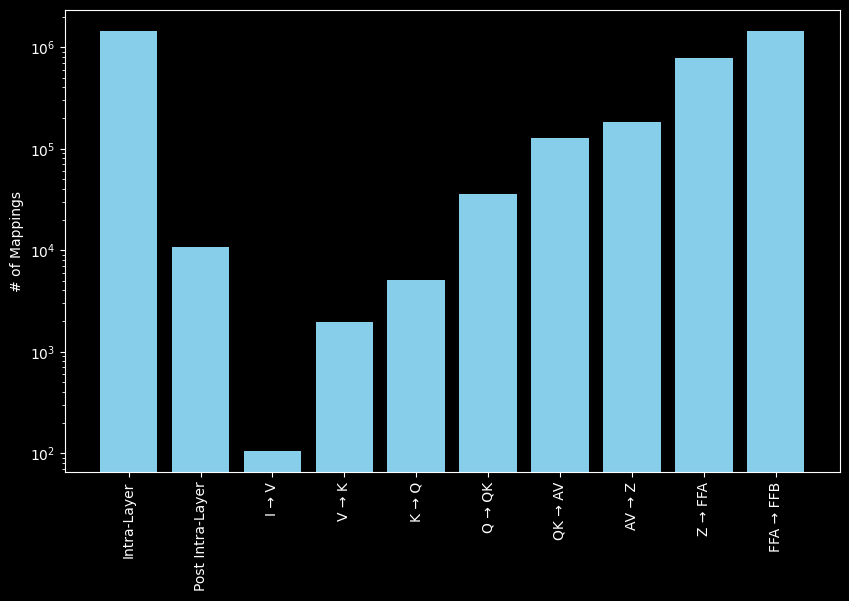

In [ ]:
v = next(iter(results.values())).n_mappings_inter.n_mappings

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(v.keys(), v.values(), color='skyblue')

values = list(v.values())
for i, value in enumerate(values):
    if i > 0 and values[i] > values[i-1]:
        print(values[i])

# Set logarithmic scale for Y-axis
plt.yscale('log')

# Add labels and title
plt.ylabel('# of Mappings')

# Rotate X-axis labels vertically
plt.xticks(rotation=90)

# Show the plot
plt.show()